In [1]:
# Imports
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from collections import namedtuple

In [2]:
# Load data
train = np.loadtxt('kepler_dataset/exoTrain.csv', delimiter=",", skiprows=1, dtype=np.float32)
test = np.loadtxt('kepler_dataset/exoTest.csv', delimiter=",", skiprows=1, dtype=np.float32)

In [3]:
# Preprocess data

# Normalize all data
train[:,1:] = (train[:,1:] - np.mean(train[:,1:], axis=1).reshape(-1,1) / np.std(train[:,1:], axis=1).reshape(-1,1))
train[:,:1] = train[:,:1] - 1

test[:,1:] = (test[:,1:] - np.mean(test[:,1:], axis=1).reshape(-1,1) / np.std(test[:,1:], axis=1).reshape(-1,1))
test[:,:1] = test[:,:1] - 1

# Augment train data
idx_one = np.where(train[:,:1] == 1)[0]
idx_zero = np.where(train[:,:1] == 0)[0]

for _ in range(len(idx_zero) - len(idx_one)):
    idx_source = np.random.randint(len(idx_one))
    time_shift = np.random.randint(train.shape[1] - 1)
    new_row = np.concatenate((train[idx_source][:1], np.roll(train[idx_source][1:], time_shift)))
    train = np.vstack([train, np.expand_dims(new_row, 0)])
    
# Shuffle train data
np.random.shuffle(train)

# Add dimension
x_train = np.expand_dims(train[:, 1:], axis=2)
x_train = np.concatenate((x_train, uniform_filter1d(x_train, axis=1, size=200)), axis=2)
y_train = np.expand_dims(train[:, 0].astype(np.int32), axis=1)

x_test = np.expand_dims(test[:, 1:], axis=2)
x_test = np.concatenate((x_test, uniform_filter1d(x_test, axis=1, size=200)), axis=2)
y_test = np.expand_dims(test[:, 0].astype(np.int32), axis=1)

In [13]:
# Create Dataset and Iterator
batch_size = 32
tf.reset_default_graph()

# Train dataset
x_train_placeholder = tf.placeholder(x_train.dtype, x_train.shape)
y_train_placeholder = tf.placeholder(y_train.dtype, y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_placeholder, y_train_placeholder))
train_dataset = train_dataset.batch(batch_size)

# Test dataset
x_test_placeholder = tf.placeholder(x_test.dtype, x_test.shape)
y_test_placeholder = tf.placeholder(y_test.dtype, y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_placeholder, y_test_placeholder))
test_dataset = test_dataset.batch(batch_size)
# Create iterator and its initializers
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
next_batch = iterator.get_next()
train_iter_init_op = {'fetches': iterator.make_initializer(train_dataset), 
                      'feed_dict': {x_train_placeholder: x_train, y_train_placeholder: y_train}}
test_iter_init_op = {'fetches': iterator.make_initializer(test_dataset), 
                     'feed_dict': {x_test_placeholder: x_test, y_test_placeholder: y_test}}

In [14]:
# Build graph
def build_inception_module(name, prev):
    xavier = tf.contrib.layers.xavier_initializer()
    prev_last_dim = prev[0].shape[1]
    
    conv1_w_1_1 = tf.get_variable(name + '_w_1_1', shape=[1, prev_last_dim, 8], initializer=xavier)
    conv1_b_1_1 = tf.get_variable(name + '_b_1_1', 8, initializer=tf.constant_initializer(0))

    conv1_w_1_2 = tf.get_variable(name + '_w_1_2', shape=[1, prev_last_dim, 8], initializer=xavier)
    conv1_b_1_2 = tf.get_variable(name + '_b_1_2', 8, initializer=tf.constant_initializer(0))

    conv1_w_1_3 = tf.get_variable(name + '_w_1_3', shape=[1, prev_last_dim, 8], initializer=xavier)
    conv1_b_1_3 = tf.get_variable(name + '_b_1_3', 8, initializer=tf.constant_initializer(0))

    conv1_w_1_4 = tf.get_variable(name + '_w_1_4', shape=[1, prev_last_dim, 8], initializer=xavier)
    conv1_b_1_4 = tf.get_variable(name + '_b_1_4', 8, initializer=tf.constant_initializer(0))

    conv1_w_5 = tf.get_variable(name + '_w_5', shape=[5, 8, 16], initializer=xavier)
    conv1_b_5 = tf.get_variable(name + '_b_5', 16, initializer=tf.constant_initializer(0))

    conv1_w_11 = tf.get_variable(name + '_w_11', shape=[11, 8, 16], initializer=xavier)
    conv1_b_11 = tf.get_variable(name + '_b_11', 16, initializer=tf.constant_initializer(0))
    
    one = tf.nn.bias_add(tf.nn.conv1d(prev, filters=conv1_w_1_1, stride=1, padding='SAME'), conv1_b_1_1)
    
    five = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(prev, filters=conv1_w_1_2, stride=1, padding='SAME'), conv1_b_1_2))
    five = tf.nn.bias_add(tf.nn.conv1d(five, filters=conv1_w_5, stride=1, padding='SAME'), conv1_b_5)
    
    eleven = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(prev, filters=conv1_w_1_3, stride=1, padding='SAME'), conv1_b_1_3))
    eleven = tf.nn.bias_add(tf.nn.conv1d(eleven, filters=conv1_w_11, stride=1, padding='SAME'), conv1_b_11)
    
    pool = tf.nn.max_pool(tf.expand_dims(prev, axis=1), ksize=[1,1,4,1], strides=[1,1,1,1], padding='SAME')
    pool = tf.nn.bias_add(tf.nn.conv1d(tf.squeeze(pool, axis=1), filters=conv1_w_1_4, stride=1, padding='SAME'), conv1_b_1_4)
    
    out = tf.nn.relu(tf.concat([one, five, eleven, pool], axis=2))
    
    return out


is_train = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

# Build graph
x_batch, y_batch = next_batch

model_out = build_inception_module('conv1', x_batch)
model_out = build_inception_module('conv2', model_out)

model_out = tf.contrib.layers.flatten(model_out)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 1, activation_fn=None)

loss = tf.losses.sigmoid_cross_entropy(y_batch, model_out)
training_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.sigmoid(model_out)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_int32(tf.greater(prediction, threshold)), y_batch)))

In [15]:
Epoch_Data = namedtuple('Epoch_data', ['loss', 'accuracy', 'predictions', 'run_time'])

def run_epoch(mode, lr=None, thresh=0.5, keep=0.5):
    if mode is 'train':
        iter_init_op = train_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy, training_op] + tf.get_collection(tf.GraphKeys.UPDATE_OPS), 
                    'feed_dict': {learning_rate: lr, keep_prob: keep, is_train: True, threshold: thresh}}
        
    elif mode is 'infer':
        iter_init_op = train_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy], 
                    'feed_dict': {keep_prob: keep, is_train: False, threshold: thresh}}
        
    start_time = time.time()
    losses = []
    predictions = []
    accs = []
    sess.run(**iter_init_op)
    while True:
        try:
            batch_outputs = sess.run(**batch_op)
            
            losses.append(batch_outputs[0])
            predictions.append(batch_outputs[1])
            accs.append(batch_outputs[2])                
        except tf.errors.OutOfRangeError:
            break
    epoch_time = time.time() - start_time
    
    return Epoch_Data(np.mean(losses), np.mean(accs), predictions, epoch_time)

In [21]:
# Train model
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())
for epoch in range(10):
    train_d = run_epoch('train', lr=0.001, keep=0.8)
    test_d = run_epoch('infer', keep=1.0) 
    
    printables = (epoch+1, train_d.run_time+test_d.run_time, train_d.accuracy, train_d.loss, test_d.accuracy)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 
    

Epoch 01	Duration: 54s	Train accuracy: 0.9015	Train loss: 0.3019	Test accuracy: 0.9158
Epoch 02	Duration: 54s	Train accuracy: 0.9012	Train loss: 0.2886	Test accuracy: 0.9166
Epoch 03	Duration: 54s	Train accuracy: 0.9007	Train loss: 0.4700	Test accuracy: 0.9170
Epoch 04	Duration: 54s	Train accuracy: 0.9023	Train loss: 0.3233	Test accuracy: 0.9162
Epoch 05	Duration: 54s	Train accuracy: 0.9011	Train loss: 0.3388	Test accuracy: 0.9157
Epoch 06	Duration: 54s	Train accuracy: 0.9021	Train loss: 0.5598	Test accuracy: 0.9158
Epoch 07	Duration: 54s	Train accuracy: 0.9027	Train loss: 0.3630	Test accuracy: 0.9159
Epoch 08	Duration: 54s	Train accuracy: 0.9012	Train loss: 0.3497	Test accuracy: 0.9163
Epoch 09	Duration: 54s	Train accuracy: 0.9034	Train loss: 0.3226	Test accuracy: 0.9166
Epoch 10	Duration: 54s	Train accuracy: 0.9027	Train loss: 0.5392	Test accuracy: 0.9161


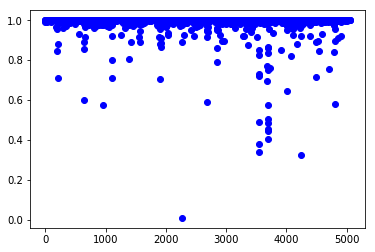

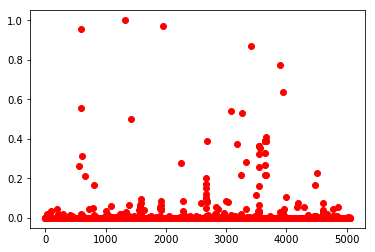

75


In [83]:
train_d = run_epoch('infer', keep=1.0)
predictions = np.concatenate(train_d.predictions)
non_idx = np.where(y_train[:,0] < 0.5)[0]
yes_idx = np.where(y_train[:,0] >= 0.5)[0]
plt.plot([predictions[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()
print (len(np.where(predictions == 0)[0]))

In [8]:
# Train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())
summary_writer = tf.summary.FileWriter('logs', sess.graph)
merged_summaries = tf.summary.merge_all()
    
train_accs = []
test_accs = []
for epoch in range(10):
    epoch_start_time = time.time()
    epoch_train_accs = []
    epoch_test_accs = []
    epoch_losses = []
        
    # train for epoch
    sess.run(**train_iter_init_op)
    while True:
        try:
            train_loss, _, predicted, train_batch_acc, summary = sess.run([loss, 
                                                                           training_op, 
                                                                           prediction, 
                                                                           accuracy,
                                                                           merged_summaries], 
                                                                          feed_dict={learning_rate: 10,
                                                                                     keep_prob: 0.5,
                                                                                     is_train: True})
            epoch_train_accs.append(train_batch_acc)
            epoch_losses.append(train_loss)
        except tf.errors.OutOfRangeError:
            break
    train_accs.append(np.mean(epoch_train_accs))
    summary_writer.add_summary(summary, epoch)
    
    
        
    # test after training
    sess.run(**test_iter_init_op)
    while True:
        try:
            test_batch_acc = sess.run([accuracy], feed_dict={keep_prob: 1.0,
                                                             is_train: False})
            epoch_test_accs.append(test_batch_acc)
        except tf.errors.OutOfRangeError:
            break
    test_accs.append(np.mean(epoch_test_accs))
        
    epoch_time = time.time() - epoch_start_time
    printables = (epoch+1, epoch_time, np.mean(epoch_train_accs), np.mean(epoch_losses), np.mean(epoch_test_accs))
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 

Epoch 01	Duration: 02s	Train accuracy: 0.6105	Train loss: 0.9370	Test accuracy: 0.9913
Epoch 02	Duration: 02s	Train accuracy: 0.6999	Train loss: 0.6880	Test accuracy: 0.9913
Epoch 03	Duration: 02s	Train accuracy: 0.8213	Train loss: 0.5160	Test accuracy: 0.9913
Epoch 04	Duration: 02s	Train accuracy: 0.8749	Train loss: 0.4271	Test accuracy: 0.9913
Epoch 05	Duration: 02s	Train accuracy: 0.8928	Train loss: 0.3848	Test accuracy: 0.9913
Epoch 06	Duration: 02s	Train accuracy: 0.9135	Train loss: 0.3564	Test accuracy: 0.9913
Epoch 07	Duration: 02s	Train accuracy: 0.9262	Train loss: 0.3270	Test accuracy: 0.9913
Epoch 08	Duration: 02s	Train accuracy: 0.9366	Train loss: 0.3066	Test accuracy: 0.9913
Epoch 09	Duration: 02s	Train accuracy: 0.9434	Train loss: 0.3001	Test accuracy: 0.9913
Epoch 10	Duration: 02s	Train accuracy: 0.9458	Train loss: 0.2884	Test accuracy: 0.9913


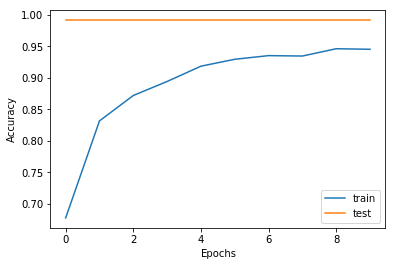

In [7]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train', 'test'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

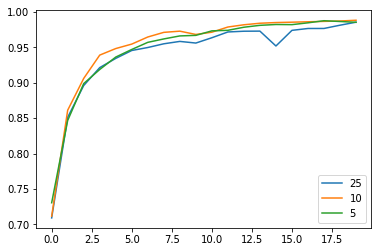

In [33]:
labels = []
for data, label in train_plots:
    if label is '5' or label is '10' or label is '25':
        plt.plot(data)
        labels.append(label)
    
plt.legend(labels, loc='lower right')
plt.show()


In [25]:
uo = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
uo

[]

In [20]:
len(train_plots)

1

[1]


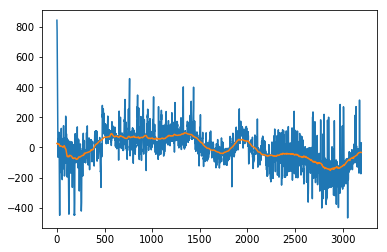

In [24]:
index = 2
print (y_test[index])
plt.plot(x_test[index])
plt.show()